In [1]:
# Bibliotecas
import numpy  as np
import pandas as pd 
import matplotlib.pyplot as plt; #%matplotlib inline
import seaborn           as sns; sns.set()

from sklearn.ensemble         import RandomForestClassifier
from sklearn.metrics          import accuracy_score
from sklearn.model_selection  import KFold, GridSearchCV, RepeatedStratifiedKFold

from scipy.stats import norm, t as tstudent, beta, gaussian_kde

from scipy.optimize import fmin, minimize, minimize_scalar, root_scalar
from scipy import integrate

import warnings
warnings.filterwarnings("ignore")

In [2]:
datos_iris = pd.read_csv("iris.csv")
datos_iris.head()

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
matriz_diseño = datos_iris.values[:,0:4]
y_real        = datos_iris.values[:,4]

print("Matriz de Diseño")
print(matriz_diseño[0:5,:])
print("")
print("Y Real")
print(y_real[0:5])

Matriz de Diseño
[[5.1 3.5 1.4 0.2]
 [4.9 3.0 1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.0 3.6 1.4 0.2]]

Y Real
['setosa' 'setosa' 'setosa' 'setosa' 'setosa']


In [4]:
# A continuación se muestra la idea general de K-Fold Validation

alpha       = 0.05
num_capas   = 10
precisiones = np.array([]) # Generamos una lista que gaurde todos lo

for indices_entrenamiento, indices_prueba in KFold(n_splits = num_capas, shuffle = False, random_state = 999 ).split( matriz_diseño ):
    
    # Datos de Entrenamiento
    x_entrenamiento = matriz_diseño[ indices_entrenamiento ]
    y_entrenamiento = y_real[ indices_entrenamiento ]
    
    # Creamos el modelo
    # Nota :: Aqui todavia se pueden jugar con distintos parámetros que no sean por defecto
    modelo_entrenamiento = RandomForestClassifier(random_state = 123 )
    
    # Ajustamos el modelo
    modelo_entrenamiento.fit( x_entrenamiento, y_entrenamiento )
    
    # Datos de Prueba
    x_prueba = matriz_diseño[ indices_prueba ]
    y_prueba = y_real[ indices_prueba ]
    
    # Métricas del modelo
    y_pronosticadas = modelo_entrenamiento.predict( x_prueba )
    precisiones = np.append( precisiones, accuracy_score( y_prueba, y_pronosticadas ) )
    
#print( 'Precisiones            =', precisiones )
print( 'Precisión Media        =', precisiones.mean() )
print( 'Rango de Precisiones   =', [ precisiones.min(), precisiones.max() ] )
print( 'Intervalo de Confianza =', [ precisiones.mean() - precisiones.std()/np.sqrt(len(matriz_diseño)) * tstudent.ppf(q = 1-alpha/2, df = np.sqrt(len(matriz_diseño)) / num_capas ),
                                     precisiones.mean() + precisiones.std()/np.sqrt(len(matriz_diseño)) * tstudent.ppf(q = 1-alpha/2, df = np.sqrt(len(matriz_diseño)) / num_capas ) ] )


Precisión Media        = 0.9400000000000001
Rango de Precisiones   = [0.7333333333333333, 1.0]
Intervalo de Confianza = [0.8810648947423594, 0.9989351052576407]


In [5]:
# Creamos un diccionario con todos los parámetros con los que queremos el modelo pruebe para encontrar la mejor combinacion
parametros = {'min_samples_leaf':[1,3,5,7,8], 'n_estimators':[10,50,100,200], 'min_samples_split':[2,3,4,5] } 

# Creamos el objeto que realiza dicha busqueda
modelos_propuestos  = GridSearchCV(
                           estimator    = RandomForestClassifier(random_state=None),
                           param_grid   = parametros,
                           scoring      = None,
                           fit_params   = None,
                           n_jobs       = None,
                           iid          = 'warn',
                           refit        = True,
                           cv           = 5,
                           verbose      = 0,
                           pre_dispatch = '2*n_jobs',
                           error_score  = 'raise-deprecating',
                           return_train_score = 'warn')

# Ajustamos el modelo
modelos_propuestos.fit( matriz_diseño, y_real )

# Mostramos la configuración del mejor modelo
print( modelos_propuestos.best_estimator_ )
print( modelos_propuestos.best_index_ )
print( modelos_propuestos.best_params_ )
print( modelos_propuestos.best_score_ )

# Guardamos el mejor modelo para continuar
el_modelo = modelos_propuestos.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
2
{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.9666666666666667


### INTERVALO DE MAXIMA DENSIDAD

In [6]:
# A continuación se muestra la idea general de K-Fold Validation
alpha       = 0.05
precisiones = np.array([]) # Generamos una lista que gaurde todos las precisiones
for indices_entrenamiento, indices_prueba in RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=12345 ).split( matriz_diseño, y_real):
    
    # Datos de Entrenamiento
    x_entrenamiento = matriz_diseño[ indices_entrenamiento ]
    y_entrenamiento = y_real[ indices_entrenamiento ]
    
    # Creamos el modelo
    # Nota :: Aqui todavia se pueden jugar con distintos parámetros que no sean por defecto
    modelo_entrenamiento = RandomForestClassifier(random_state = 123 )
    
    # Ajustamos el modelo
    modelo_entrenamiento.fit( x_entrenamiento, y_entrenamiento )
    
    # Datos de Prueba
    x_prueba = matriz_diseño[ indices_prueba ]
    y_prueba = y_real[ indices_prueba ]
    
    # Métricas del modelo
    y_pronosticadas = modelo_entrenamiento.predict( x_prueba )
    precisiones = np.append( precisiones, accuracy_score( y_prueba, y_pronosticadas ) )

Alpha-> 28.420047814207727 Beta-> 1.72851775956285


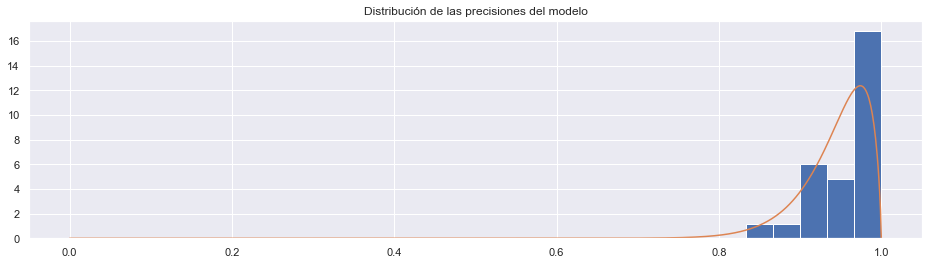

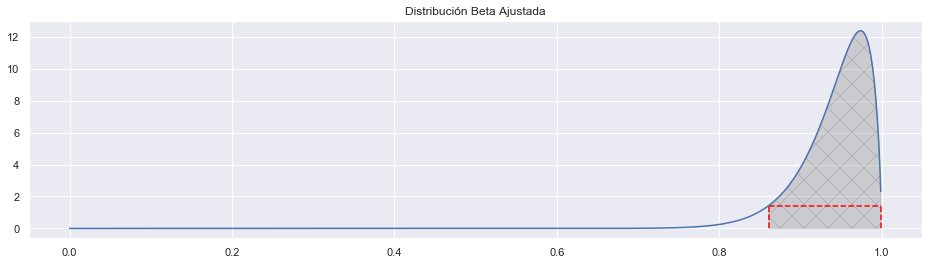

Intervalo Aprox. Normal ::  [0.9143406428674042, 0.9709926904659288] 0.0566520475985246 0.96
Intervalo Percentiles   ::  (0.8378051805718367, 0.9943289640286276) 0.15652378345679085 0.9500000000000002
Intervalo Mínimo        ::  (0.861010114721443, 0.9994928847580022) 0.1384827700365593 0.9500000555396871
Precisión Aprox. Normal ::  0.9426666666666665
Precisión Beta Media    ::  0.9426666666666667
Precisión Beta Moda     ::  0.9741188318227592


In [7]:
# Estimamos los parámetros de la distribución Beta
x_barra  = precisiones.mean()
desv_est = precisiones.std()
alpha_est     = x_barra * ( ( x_barra * (1-x_barra) ) / ( desv_est ** 2 ) - 1 )
beta_est      = alpha_est * (1 - x_barra) / x_barra
moda_est      = (alpha_est-1)/(alpha_est+beta_est-2)
beta_ajustada = beta(a=alpha_est,b=beta_est)
intervalo     = beta_ajustada.interval(alpha = 1-alpha)
longitud      = intervalo[1] - intervalo[0]
print("Alpha->", alpha_est, "Beta->", beta_est)

# Generamos una grafica para mostrar la estimacion de una beta
plt.subplots( nrows=1, ncols=1, figsize=(16,4) )
plt.title("Distribución de las precisiones del modelo")
plt.hist( x=precisiones, bins = 5, density=True )
plt.plot( np.linspace(start=0,stop=1,num=1000), beta_ajustada.pdf(x=np.linspace(start=0,stop=1,num=1000) ) )
plt.show()

# Definimos nuestra función de error para encontrar el punto de corte adecuado
# que nos proporcione el Intervalo de Menor Lonigtud
def funcion_error(y0, alpha=0.05, *args):
    from scipy import integrate
    def beta_modificada( k ):
        pdf = beta_ajustada.pdf( x = k )
        #return np.array( [ x if x > y0 else 0 for x in pdf ] )
        return pdf if pdf > y0 else 0 
    area_curva = integrate.quad( func = beta_modificada, a = 0, b = 1, limit = 1000, epsabs=1E-5, epsrel=1E-5 )[0]
    #area_curva = integrate.quadrature( func = beta_modificada, a = 0, b = 1, maxiter = 1000  )[0]
    #area_curva = integrate.fixed_quad( func = beta_modificada, a = 0, b = 1, n = 500 )[0]
    #return np.abs( area_curva - ( 1 - alpha ) )
    return ( area_curva - ( 1 - alpha ) )**2

# Optimizamos la función de error tal que nos de el punto de corte en Y tal que acumulemos el (1-alpha)% de probabilidad
# Luego, como sabemos que es unimodal, el punto de corte solo debemos encontrar 2 puntos en el eje x
# por lo que uno de ellos estará a la izquierda de la moda y el otro a la derecha de la moda
#y_optima = fmin(func = funcion_error, x0 = np.mean( beta_ajustada.pdf( beta_ajustada.ppf([alpha/2, 1-alpha/2]) ) ), disp = False )
y_optima = minimize_scalar(fun = funcion_error, bounds = np.sort( beta_ajustada.pdf( beta_ajustada.ppf([alpha/2, 1-alpha/2]) ) ) , method = "Bounded" ).x
lim_inf  = root_scalar(f = lambda x: beta_ajustada.pdf(x) - y_optima, method="bisect", bracket=[0,moda_est] ).root
lim_sup  = root_scalar(f = lambda x: beta_ajustada.pdf(x) - y_optima, method="bisect", bracket=[moda_est,1] ).root
intervalo_min = (lim_inf, lim_sup)
longitud_min  = lim_sup - lim_inf

# Graficamos la distribución Beta Estimada
x = np.arange(start=0, stop=1, step=0.001)
y = beta_ajustada.pdf(x=x)
plt.subplots(nrows=1, ncols=1, figsize=(16,4) )
plt.title("Distribución Beta Ajustada")
plt.plot( x, y )
plt.hlines( y=y_optima , xmin = lim_inf, xmax = lim_sup,  color="red", linestyle = "--" )
plt.vlines( x=lim_inf  , ymin = 0,       ymax = y_optima, color="red", linestyle = "--" )
plt.vlines( x=lim_sup  , ymin = 0,       ymax = y_optima, color="red", linestyle = "--" )
x_fill = np.arange(lim_inf, lim_sup, 1/1000)
y_fill = beta_ajustada.pdf(x = x_fill)
plt.fill_between( x_fill, y_fill, color = "gray", hatch = "x", alpha = 0.3  )
plt.show()

# INTERVALOS DE CONFIANZA
intervalo_normal = [ precisiones.mean() - precisiones.std()/np.sqrt(len(matriz_diseño)) * tstudent.ppf(q = 1-alpha/2, df = np.sqrt(len(matriz_diseño)) / num_capas ),
                                      precisiones.mean() + precisiones.std()/np.sqrt(len(matriz_diseño)) * tstudent.ppf(q = 1-alpha/2, df = np.sqrt(len(matriz_diseño)) / num_capas ) ]
cuantiles_normal = np.quantile( a = precisiones, q = [0.05/2, 1-0.05/2] )
print( 'Intervalo Aprox. Normal :: ', intervalo_normal, intervalo_normal[1]-intervalo_normal[0], np.mean(precisiones<=cuantiles_normal[1]) - np.mean(precisiones<=cuantiles_normal[0])  )
print( "Intervalo Percentiles   :: ", intervalo, longitud, beta_ajustada.cdf(intervalo[1]) - beta_ajustada.cdf(intervalo[0]) )
print( "Intervalo Mínimo        :: ", intervalo_min, longitud_min, beta_ajustada.cdf(intervalo_min[1]) - beta_ajustada.cdf(intervalo_min[0]) )

# ESTIMACION PUNTUAL
print( 'Precisión Aprox. Normal :: ', precisiones.mean() )
print( 'Precisión Beta Media    :: ', alpha_est / (alpha_est + beta_est) )
print( 'Precisión Beta Moda     :: ', moda_est )



In [8]:
pd.value_counts( values = precisiones, sort = False ).reset_index().sort_values(by='index')

,index,0
5,0.833333,1
1,0.866667,1
2,0.900000,5
3,0.933333,4
4,0.966667,11
0,1.000000,3
